In [1]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
#train_df=pd.read_pickle('./data/train_df.pickle')
#test_df=pd.read_pickle('./data/test_df.pickle')
train_df=pd.read_pickle('./data/train_df_nopunc.pickle')
test_df=pd.read_pickle('./data/test_df_nopunc.pickle')

In [3]:
comment_lengths=list()
comment_list=train_df['text'].tolist()
for i in tqdm(range(len(comment_list))):
    comment=comment_list[i]
    temp1=len(comment.split())
    comment_lengths.append(temp1)

    

100%|████████████████████████████| 3600000/3600000 [00:26<00:00, 134838.57it/s]


In [4]:
comment_lengths_test=list()
comment_list_test=test_df['text'].tolist()
for i in tqdm(range(len(comment_list_test))):
    comment=comment_list_test[i]
    temp1=len(comment.split())
    comment_lengths_test.append(temp1)

100%|██████████████████████████████| 400000/400000 [00:03<00:00, 131573.67it/s]


In [5]:
#word2vec_simple_from_tf=np.load('./data/word2vec_simple.npz')
word2vec_simple_from_tf=np.load('./data/word2vec_1M_FT.npz')


In [6]:
embeddings=word2vec_simple_from_tf['arr_0']
word_dict=word2vec_simple_from_tf['arr_1'].tolist()
reverse_dict=word2vec_simple_from_tf['arr_2'].tolist()
embedding_size=embeddings.shape[1]
comment_vector_size=embedding_size*max(comment_lengths)
num_comments=len(comment_list)
train_labels=(train_df['label']).tolist()
n_embeddings,d_embeddings=embeddings.shape

In [7]:
comments_with_word_indices=np.zeros(shape=(num_comments,max(comment_lengths)),dtype='int32')
for i in tqdm(range(len(comment_list))):
    comment=comment_list[i]
    comment_words=comment.split()
    for j,word in enumerate(comment_words):
        comments_with_word_indices[i,j]=word_dict.get(word,0)

100%|█████████████████████████████| 3600000/3600000 [03:01<00:00, 19831.33it/s]


In [8]:
def generate_batch(batch_size):
    batch_indices=random.sample(range(num_comments),batch_size)
    batch_inputs=comments_with_word_indices[batch_indices,:]
    batch_labels=np.reshape(np.asarray([train_labels[idx] for idx in batch_indices])-1,(batch_size,1))
    return batch_inputs, batch_labels, batch_indices

In [9]:
#sanity check
a=generate_batch(2) 
b=a[0][0]
index1=a[2][0]
c=[o for o in b if o!=0]
print(len(c))
print(len(comment_list[index1].split()))
label1=a[1][0]
print(label1)
print(train_df['label'][index1])


28
28
[1]
2


In [10]:
#creating test dataset
num_comments_test=len(comment_list_test)
test_labels=(test_df['label']-1).tolist()
test_dataset=np.zeros((num_comments_test,max(comment_lengths)),dtype='int32')
for i in tqdm(range(num_comments_test)):
    comment=comment_list_test[i]
    comment_as_word=comment.split()
    for j,word in enumerate(comment_as_word):
        word_index=word_dict.get(word,0)
        test_dataset[i,j]=word_index

100%|███████████████████████████████| 400000/400000 [00:21<00:00, 18987.96it/s]


In [17]:
import time
num_steps=15001
batch_size=64
graph=tf.Graph()
batch_timing=0
run_timing=0
num_filters_l1=200
num_filters_l2=100
num_filters_l3=50
num_filters_l4=20
kernel_size_l1=5
kernel_size_l2=4
kernel_size_l3=3
kernel_size_l4=2
restore_sess=1
test_batch_size=int(num_comments_test/100)
validation_batch_size=500

#model_name="./ckpt/LR_word2vec.ckpt"
model_name="./ckpt/CNN5_word2vec_1M_FT_experimental.ckpt"
steps_display=min(int((num_steps-1)/20),1000)
with graph.as_default():
    inputs=tf.placeholder(tf.int32, shape=(batch_size,max(comment_lengths)))
    test_inputs=tf.placeholder(tf.int32, shape=(test_batch_size,max(comment_lengths)))
    validation_inputs=tf.placeholder(tf.int32, shape=(validation_batch_size,max(comment_lengths)))
    labels=tf.placeholder(tf.float32, shape=(batch_size,1))
    embedding_matrix=tf.placeholder(tf.float32, shape=(n_embeddings,d_embeddings))
    layer1_weights=tf.Variable(tf.truncated_normal([kernel_size_l1,d_embeddings,num_filters_l1],stddev=0.1))
    layer2_weights=tf.Variable(tf.truncated_normal([kernel_size_l2,num_filters_l1,num_filters_l2],stddev=0.1))
    layer3_weights=tf.Variable(tf.truncated_normal([kernel_size_l3,num_filters_l2,num_filters_l3],stddev=0.1))
    layer4_weights=tf.Variable(tf.truncated_normal([kernel_size_l4,num_filters_l3,num_filters_l4],stddev=0.1))
    
    
    hidden_weights=tf.Variable(tf.truncated_normal([max(comment_lengths)*num_filters_l4,1],stddev=0.1))
    hidden_biases=tf.Variable(tf.constant(1.0, shape=[1]))
    
    def model_graph(data):
        batch_embeddings=tf.nn.embedding_lookup(embedding_matrix,data)
        conv1=tf.nn.conv1d(batch_embeddings,layer1_weights,stride=1,padding='SAME')
        conv1=tf.nn.relu(conv1)
        conv2=tf.nn.conv1d(conv1,layer2_weights,stride=1,padding='SAME')
        conv2=tf.nn.relu(conv2)
        conv3=tf.nn.conv1d(conv2,layer3_weights,stride=1,padding='SAME')
        conv3=tf.nn.relu(conv3)
        conv4=tf.nn.conv1d(conv3,layer4_weights,stride=1,padding='SAME')
        conv4=tf.nn.relu(conv4)
        shape=conv4.get_shape().as_list()
        conv4=tf.reshape(conv4,[shape[0],shape[1],shape[2],1])
        pool3=tf.nn.max_pool(conv4,[1,1,num_filters_l4,1],strides=[1,1,1,1],padding='SAME')
        shape=pool3.get_shape().as_list()
        flat1=tf.reshape(pool3,[shape[0],shape[1]*shape[2]*shape[3]])
        flat1=tf.nn.dropout(flat1,keep_prob=0.5)
        y_pred_model=tf.matmul(flat1,hidden_weights)+hidden_biases
        return y_pred_model
    
    y_pred=model_graph(inputs)
    y_pred_test=model_graph(test_inputs)
    y_pred_validation=model_graph(validation_inputs)
    test_predictions=tf.round(tf.sigmoid(y_pred_test))
    validation_predictions=tf.round(tf.sigmoid(y_pred_validation))
    train_predictions=tf.round(tf.sigmoid(y_pred))
    x_entropy=tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred,labels=labels)
    loss =tf.reduce_mean(x_entropy)
    optimizer = tf.train.AdamOptimizer().minimize(loss)
    init = tf.global_variables_initializer()
    saver=tf.train.Saver()

sess=tf.Session(graph=graph)
with sess.as_default():
    init.run()
    if restore_sess==1:
        try:
            saver.restore(sess,model_name)
        except:
            print('Unexpected Error: model cannot be restored')
    print('initialized')
    loss_val_sum=0
    for i in range(num_steps):
        time1=time.time()
        batch_inputs,batch_labels,_=generate_batch(batch_size)
        time2=time.time()
        feed_dict={inputs:batch_inputs,labels:batch_labels,embedding_matrix:embeddings}
        _,loss_val,train_preds=sess.run([optimizer,loss,train_predictions],feed_dict=feed_dict)
        time3=time.time()
        batch_timing += time2-time1
        run_timing += time3-time2
        loss_val_sum += loss_val
        if i % steps_display==0 and i!=0:
            validation_batch,validation_labels,_=generate_batch(validation_batch_size)
            #validation_batch=batch_inputs
            #validation_labels=batch_labels
            validation_preds=sess.run(validation_predictions,
                                      feed_dict={validation_inputs:validation_batch,embedding_matrix:embeddings})            
            print('Step:',i,
                  ',Average loss in',steps_display, 'steps:',"{0:.3f}".format(loss_val_sum/steps_display),',batch time:'
                  ,"{0:.2f}".format(batch_timing),',Run time:',"{0:.2f}".format(run_timing)
                  ,'Batch Accuracy:', "{:4.2f}".format(100*accuracy_score(batch_labels,train_preds))
                  ,'Valid accuracy:',"{:4.2f}".format(100*accuracy_score(validation_labels,validation_preds)))
            batch_timing=0
            run_timing=0
            loss_val_sum=0
    try:
        saver.save(sess,model_name)
        print('Model saved!')
    except:
        print('Model could not be saved')

INFO:tensorflow:Restoring parameters from ./ckpt/CNN5_word2vec_1M_FT_experimental.ckpt
initialized
Step: 750 ,Average loss in 750 steps: 0.330 ,batch time: 0.26 ,Run time: 896.93 Batch Accuracy: 87.50 Valid accuracy: 83.00
Step: 1500 ,Average loss in 750 steps: 0.295 ,batch time: 0.36 ,Run time: 870.80 Batch Accuracy: 90.62 Valid accuracy: 92.20
Step: 2250 ,Average loss in 750 steps: 0.276 ,batch time: 0.16 ,Run time: 854.67 Batch Accuracy: 84.38 Valid accuracy: 89.00
Step: 3000 ,Average loss in 750 steps: 0.261 ,batch time: 0.39 ,Run time: 852.95 Batch Accuracy: 84.38 Valid accuracy: 88.40
Step: 3750 ,Average loss in 750 steps: 0.255 ,batch time: 0.20 ,Run time: 852.91 Batch Accuracy: 92.19 Valid accuracy: 89.40
Step: 4500 ,Average loss in 750 steps: 0.238 ,batch time: 0.20 ,Run time: 852.72 Batch Accuracy: 90.62 Valid accuracy: 92.20
Step: 5250 ,Average loss in 750 steps: 0.231 ,batch time: 0.19 ,Run time: 852.46 Batch Accuracy: 98.44 Valid accuracy: 92.40
Step: 6000 ,Average loss in

In [18]:
with sess.as_default():
    init.run()
    try:
        saver.restore(sess,model_name)
    except:
        print('Unexpected Error: model cannot be restored')
    print('initialized')
    y_pred=np.zeros((num_comments_test,1))
    for i in tqdm(range(int(num_comments_test/test_batch_size))):
        test_batch=test_dataset[i*test_batch_size:(i+1)*test_batch_size,:]
        y_pred_batch=test_predictions.eval(feed_dict={test_inputs:test_batch,embedding_matrix:embeddings})
        y_pred[i*test_batch_size:(i+1)*test_batch_size,:]=y_pred_batch

INFO:tensorflow:Restoring parameters from ./ckpt/CNN5_word2vec_1M_FT_experimental.ckpt
initialized


100%|████████████████████████████████████████| 100/100 [29:39<00:00, 17.80s/it]


In [19]:
y_true=test_labels
accuracy=accuracy_score(y_true,y_pred)
precision=average_precision_score(y_true,y_pred)
recall=recall_score(y_true,y_pred)
f1=f1_score(y_true,y_pred)
print('Accuracy: {:4.2f}%, Precision: {:4.2f}%, Recall: {:4.2f}%, F1_score: {:4.2f}%'.format(accuracy*100,precision*100,recall*100,f1*100))

Accuracy: 92.38%, Precision: 88.08%, Recall: 95.58%, F1_score: 92.62%


In [27]:
#comparing with the lockbox version
with sess.as_default():
    init.run()
    try:
        saver.restore(sess,"./ckpt/Lockbox/CNN5_word2vec_1M_FT_experimental.ckpt")
    except:
        print('Unexpected Error: model cannot be restored')
    print('initialized')
    y_pred=np.zeros((num_comments_test,1))
    for i in tqdm(range(int(num_comments_test/test_batch_size))):
        test_batch=test_dataset[i*test_batch_size:(i+1)*test_batch_size,:]
        y_pred_batch=test_predictions.eval(feed_dict={test_inputs:test_batch,embedding_matrix:embeddings})
        y_pred[i*test_batch_size:(i+1)*test_batch_size,:]=y_pred_batch

INFO:tensorflow:Restoring parameters from ./ckpt/Lockbox/CNN5_word2vec_1M_FT_experimental.ckpt
initialized


100%|████████████████████████████████████████| 100/100 [14:11<00:00,  8.51s/it]


In [28]:
y_true=test_labels
accuracy=accuracy_score(y_true,y_pred)
precision=average_precision_score(y_true,y_pred)
recall=recall_score(y_true,y_pred)
f1=f1_score(y_true,y_pred)
print('Accuracy: {:4.2f}%, Precision: {:4.2f}%, Recall: {:4.2f}%, F1_score: {:4.2f}%'.format(accuracy*100,precision*100,recall*100,f1*100))

Accuracy: 92.19%, Precision: 88.41%, Recall: 93.60%, F1_score: 92.30%


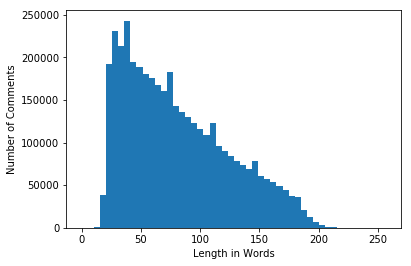

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.xlabel('Length in Words')
plt.ylabel('Number of Comments')
plt.hist(comment_lengths+comment_lengths_test,bins=50)
plt.savefig('comment_lengths.png',bbox_inches ='tight')

In [24]:
labels=(test_df['label']-1).tolist()+(train_df['label']-1).tolist()
pos=labels.count(1)
neg=labels.count(0)
print(pos,neg)

2000000 2000000
